In [9]:

import numpy as np
import pandas as pd
from scipy.signal import welch
import ace_tools_open as tools; 
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def bandpass_filter(data, fs, low=1, high=30, order=5):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

df = pd.read_csv("data/adhdata.csv")
df.head()
print(df.shape)
print(df.columns)




(2166383, 21)
Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')


In [10]:
filtered_eeg = bandpass_filter(df[channel_names].values, fs=128)


filtered_df = df.copy()
filtered_df[channel_names] = filtered_eeg

# Display the filtered dataset
# tools.display_dataframe_to_user(name="Filtered EEG Dataset", dataframe=filtered_df)
print(filtered_df.shape)
print(filtered_df.columns)

(2166383, 21)
Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')


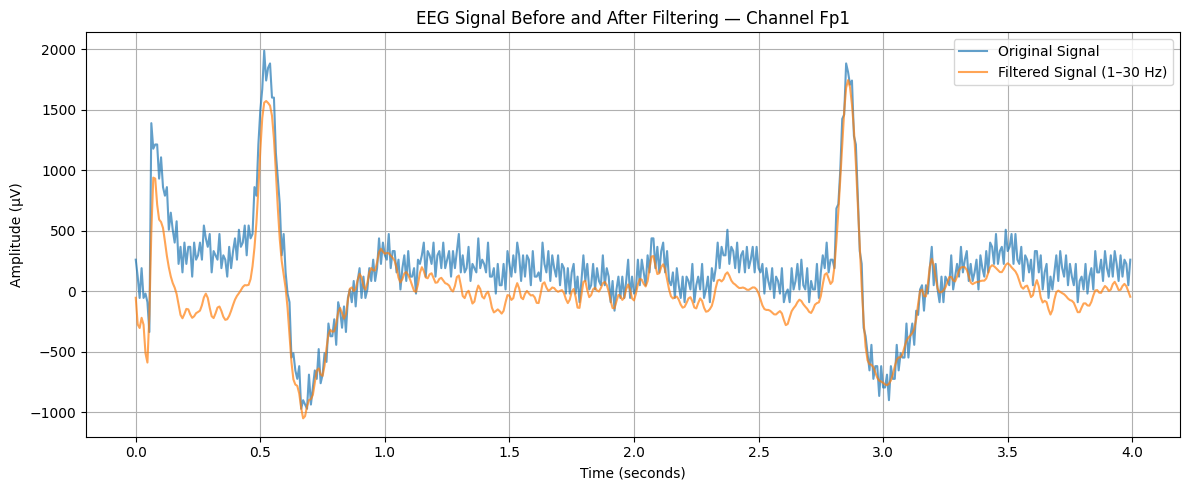

In [11]:
channel = 'Fp1'
samples_to_plot = 512  # About 4 seconds of data

# Extract the original and filtered signals
original_signal = df[channel].values[:samples_to_plot]
filtered_signal = filtered_df[channel].values[:samples_to_plot]
time = np.arange(samples_to_plot) / 128  # Time axis in seconds

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time, original_signal, label='Original Signal', alpha=0.7)
plt.plot(time, filtered_signal, label='Filtered Signal (1–30 Hz)', alpha=0.7)
plt.title(f'EEG Signal Before and After Filtering — Channel {channel}')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
features = []
df = filtered_df.copy()
print(df.shape)
print(df.columns)

fs = 128  # Sampling rate in Hz
epoch_length = 2 * fs  # 2 seconds = 256 samples
step_size = fs  # 50% overlap = 128 samples

# Process each subject individually
for subject_id in df['ID'].unique():
    subject_data = df[df['ID'] == subject_id].reset_index(drop=True)
    eeg_data = subject_data[channel_names].values
    label = subject_data['Class'].iloc[0]

    for start in range(0, len(eeg_data) - epoch_length + 1, step_size):
        epoch = eeg_data[start:start + epoch_length, :]
        feature_row = {'Subject_ID': subject_id, 'Class': label}

        for i, ch in enumerate(channel_names):
            f, Pxx = welch(epoch[:, i], fs=fs, nperseg=epoch_length)
            delta_power = np.trapezoid(Pxx[(f >= 0.5) & (f < 4)], f[(f >= 0.5) & (f < 4)])
            theta_power = np.trapezoid(Pxx[(f >= 4) & (f <= 8)], f[(f >= 4) & (f <= 8)])
            alpha_power = np.trapezoid(Pxx[(f >= 8) & (f <= 13)], f[(f >= 8) & (f <= 13)])
            beta_power = np.trapezoid(Pxx[(f >= 13) & (f <= 30)], f[(f >= 13) & (f <= 30)])
            tbr = theta_power / beta_power if beta_power != 0 else 0
            feature_row[f'TBR_{ch}'] = tbr
            feature_row[f'Feature1_{ch}'] = delta_power + theta_power + alpha_power + beta_power

        features.append(feature_row)


tbr_df_multi = pd.DataFrame(features)

# Binary label
tbr_df_multi['Label'] = (tbr_df_multi['Class'] == 'ADHD').astype(int)
print(tbr_df_multi.shape)
print(tbr_df_multi.columns)
tbr_df_multi.head()

# Define TBR and Feature1 feature names
tbr_features = [f'TBR_{ch}' for ch in channel_names]
feature1_features = [f'Feature1_{ch}' for ch in channel_names]

# Combine both feature types
X = tbr_df_multi[tbr_features + feature1_features]
y = tbr_df_multi['Label']

(2166383, 21)
Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')
(16749, 41)
Index(['Subject_ID', 'Class', 'TBR_Fp1', 'Feature1_Fp1', 'TBR_Fp2',
       'Feature1_Fp2', 'TBR_F3', 'Feature1_F3', 'TBR_F4', 'Feature1_F4',
       'TBR_C3', 'Feature1_C3', 'TBR_C4', 'Feature1_C4', 'TBR_P3',
       'Feature1_P3', 'TBR_P4', 'Feature1_P4', 'TBR_O1', 'Feature1_O1',
       'TBR_O2', 'Feature1_O2', 'TBR_F7', 'Feature1_F7', 'TBR_F8',
       'Feature1_F8', 'TBR_T7', 'Feature1_T7', 'TBR_T8', 'Feature1_T8',
       'TBR_P7', 'Feature1_P7', 'TBR_P8', 'Feature1_P8', 'TBR_Fz',
       'Feature1_Fz', 'TBR_Cz', 'Feature1_Cz', 'TBR_Pz', 'Feature1_Pz',
       'Label'],
      dtype='object')


In [13]:
from sklearn.model_selection import GroupShuffleSplit

groups = tbr_df_multi['Subject_ID']
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(X_train.shape)

print(X_test.shape)


(11450, 38)
(5299, 38)


In [14]:

train_subjects = set(tbr_df_multi.iloc[train_idx]['Subject_ID'])
test_subjects = set(tbr_df_multi.iloc[test_idx]['Subject_ID'])

# Check for overlap
overlap = train_subjects.intersection(test_subjects)

# Print result
if len(overlap) == 0:
    print("✅ Success: No subject appears in both training and test sets.")
else:
    print(f"❌ Warning: Overlap found in Subject_IDs: {overlap}")


✅ Success: No subject appears in both training and test sets.


In [15]:
# Classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (RBF kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3)
}

# Train and report
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()

c:\Users\43699\OneDrive\Desktop\Documents\MCI\8SE\AI_project\adhd-eeg-project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.49      0.42      0.46      2177
           1       0.63      0.70      0.66      3122

    accuracy                           0.58      5299
   macro avg       0.56      0.56      0.56      5299
weighted avg       0.58      0.58      0.58      5299


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2177
           1       0.73      0.75      0.74      3122

    accuracy                           0.69      5299
   macro avg       0.68      0.68      0.68      5299
weighted avg       0.69      0.69      0.69      5299


=== SVM (RBF kernel) ===
              precision    recall  f1-score   support

           0       0.62      0.38      0.47      2177
           1       0.66      0.84      0.74      3122

    accuracy                           0.65      5299
   macro avg       0.64      0.61      0.60      52